# Imports

In [1]:
#Imports
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import lightgbm as lgb
from scipy.stats import spearmanr

sns.set_style("white")
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
set_matplotlib_formats('svg')

plt.rcParams["font.family"] = "Times New Roman" # !!!!
plt.rcParams.update({'font.size': 32})


/var/folders/63/wxl6xn215jv9b9snrf52bxd00000gq/T/ipykernel_57050/3791004227.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Loading Files

In [2]:
df_config = pd.read_csv("data/pile/tiny_config_1M_pile.csv")
df_config.head()

,index,ArXiv,FreeLaw,NIH ExPorter,PubMed Central,Wikipedia (en),DM Mathematics,Github,PhilPapers,Stack Exchange,Enron Emails,Gutenberg (PG-19),Pile-CC,Ubuntu IRC,EuroParl,HackerNews,PubMed Abstracts,USPTO Backgrounds
0,1,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.209,0.787,0.000,0.000,0.000,0.000,0.000
1,2,0.025,0.002,0.05,0.000,0.047,0.000,0.304,0.009,0.003,0.001,0.103,0.299,0.024,0.040,0.090,0.001,0.000
2,3,0.679,0.000,0.00,0.044,0.000,0.001,0.000,0.003,0.000,0.001,0.000,0.269,0.000,0.000,0.000,0.003,0.000
3,4,0.008,0.025,0.00,0.007,0.015,0.000,0.315,0.000,0.216,0.000,0.109,0.006,0.000,0.009,0.000,0.054,0.237
4,5,0.193,0.003,0.00,0.060,0.010,0.061,0.031,0.000,0.417,0.000,0.128,0.022,0.000,0.008,0.001,0.000,0.067


In [3]:
df_wandb = pd.read_csv("data/pile/tiny_wandb_1M_1000_pile_4B.csv")
df_wandb.head()

,index,ArXiv,FreeLaw,PubMed Central,Wikipedia (en),DM Mathematics,Github,Stack Exchange,Gutenberg (PG-19),Pile-CC,Ubuntu IRC,HackerNews,PubMed Abstracts,USPTO Backgrounds
0,1,7.025587,5.360581,6.536047,5.639575,5.820675,6.632823,6.107804,4.726567,5.169478,7.224245,5.206871,5.892633,5.417375
1,2,4.738542,5.466145,5.808464,5.425566,4.614905,4.141744,4.922904,4.954422,5.343519,5.278083,4.801190,5.653642,5.584351
2,3,3.730259,5.793972,4.721465,5.933120,4.077418,6.540956,6.079324,5.561454,5.506681,7.476072,5.495143,5.626058,5.507367
3,4,4.887355,5.040224,5.371085,5.858129,5.298434,4.150363,4.455072,5.095428,5.828740,7.491353,5.551083,5.268948,4.475535
4,5,4.034541,5.597910,4.693126,5.814626,2.008140,4.485220,4.249207,5.003798,5.760408,7.100966,5.329304,5.664215,4.813331


In [4]:
X = df_config[df_config.columns[1:]].values
X.shape

(1000, 17)

In [5]:
y = df_wandb[df_wandb.columns[1:]].values
y.shape

(1000, 13)

In [6]:
# Split the train and val set
i = 128

X_val = X[:i]
y_val = y[:i]

X_train = X[i:]
y_train = y[i:]

In [7]:
KEY_METRICS = df_wandb.columns[1:].tolist()
KEY_METRICS

['ArXiv',
 'FreeLaw',
 'PubMed Central',
 'Wikipedia (en)',
 'DM Mathematics',
 'Github',
 'Stack Exchange',
 'Gutenberg (PG-19)',
 'Pile-CC',
 'Ubuntu IRC',
 'HackerNews',
 'PubMed Abstracts',
 'USPTO Backgrounds']

# Fitting

In [8]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    "num_iterations": 1000, 
    'seed': 42,
    'learning_rate': 1e-2,
    "verbosity": -1,
}

predictor = []

for i in range(len(KEY_METRICS)):

    target = y_train[:, i]
    val_target = y_val[:, i]
        
    np.random.seed(42)
    
    gbm = lgb.LGBMRegressor(**hyper_params)

    reg = gbm.fit(X_train, target,
        eval_set=[(X_val, val_target)],
        eval_metric='l2', callbacks=[
        lgb.early_stopping(stopping_rounds=3, verbose=False),
    ])
    r, p = spearmanr(reg.predict(X_val), val_target)
    print(i, KEY_METRICS[i], "Correlation: {}".format(np.round(r*100, 2)))

    predictor.append(reg)
    # break

0 ArXiv Correlation: 99.73
1 FreeLaw Correlation: 99.7
2 PubMed Central Correlation: 99.27
3 Wikipedia (en) Correlation: 99.46
4 DM Mathematics Correlation: 97.92
5 Github Correlation: 99.73
6 Stack Exchange Correlation: 99.73
7 Gutenberg (PG-19) Correlation: 99.08
8 Pile-CC Correlation: 99.0
9 Ubuntu IRC Correlation: 97.54
10 HackerNews Correlation: 98.94
11 PubMed Abstracts Correlation: 99.42
12 USPTO Backgrounds Correlation: 99.19


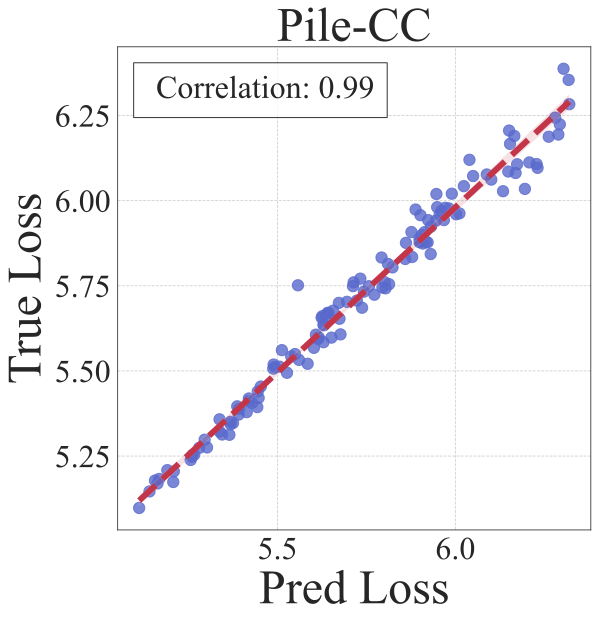

In [9]:
# Visualize the fitting on Pile-CC
selected = 8

data = {
    'True Loss': y_val[:, selected],
    'Pred Loss': predictor[selected].predict(X_val)
}

graph = sns.jointplot(data, x='Pred Loss', y='True Loss', kind='reg',
                      height=10, 
                      scatter_kws={'s': 128, 'color': '#5969CB'},
                  joint_kws={'line_kws': {
                      'color': '#C3364A', 
                                          'linewidth': 6,
                      'linestyle': 'dashed',
                  }},
                  marginal_kws={'line_kws': {
                      'color': '#5969CB', 
                      'linewidth': 6}}
             )

r, p = spearmanr(data['Pred Loss'], data['True Loss'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)

graph.ax_joint.legend(
    [phantom],['Correlation: {:.2f}'.format(np.round(r, 2))],
    edgecolor='black', 
           fancybox=False,
           prop={'size': 32, }, 
           handlelength=-0.5
)

graph.ax_joint.set_title(KEY_METRICS[selected], fontdict={
    'size':48
})
graph.ax_joint.set_ylabel('True Loss', fontdict={
    'size':48
})
graph.ax_joint.set_xlabel('Pred Loss', fontdict={
    'size':48
})

graph.ax_marg_x.remove()
graph.ax_marg_y.remove()

graph.ax_joint.grid(True, ls='dashed')
graph.ax_joint.spines[['right', 'top']].set_visible(True)

plt.savefig('viz/1M_pile_cc_Joint.pdf')

# Simulate

In [10]:
# simulate for Pile-CC
selected = 8

prior_dist = [0.11328527, 0.07960865, 0.00391349, 0.1853759, 
              0.05108136, 0.01596293, 0.10175077, 0.00370752, 
              0.06652935, 0.00175077, 0.02708548, 0.23686921, 
              0.01184346, 0.00792997, 0.00803296, 0.03882595, 
              0.04644696]

np.random.seed(42)
samples = np.random.dirichlet(prior_dist * 1, 100000)
samples.shape

(100000, 17)

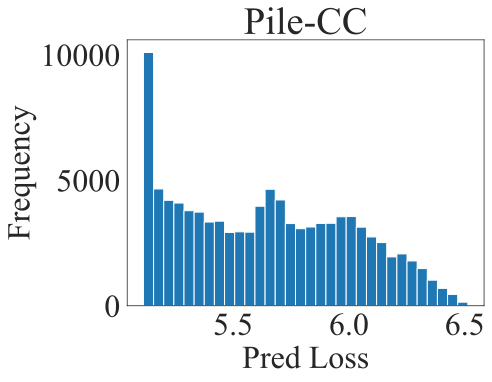

In [11]:
simulation = predictor[selected].predict(samples)

plt.hist(simulation, bins=32)

plt.title(KEY_METRICS[selected])
plt.xlabel('Pred Loss')
plt.ylabel('Frequency')
print()

In [12]:
k = 128
top_k_samples = samples[np.argsort(simulation)[0:k]]
top_k_samples.shape

(128, 17)

In [17]:
df = pd.DataFrame(data=np.concatenate([np.array([prior_dist]), 
                                       top_k_samples], axis=0), columns=df_config.columns[1:])
df = pd.melt(df)
df['type'] = (['Human']+['RegMix']*top_k_samples.shape[0])*len(df_config.columns[1:])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variable  2193 non-null   object 
 1   value     2193 non-null   float64
 2   type      2193 non-null   object 
dtypes: float64(1), object(2)
memory usage: 51.5+ KB


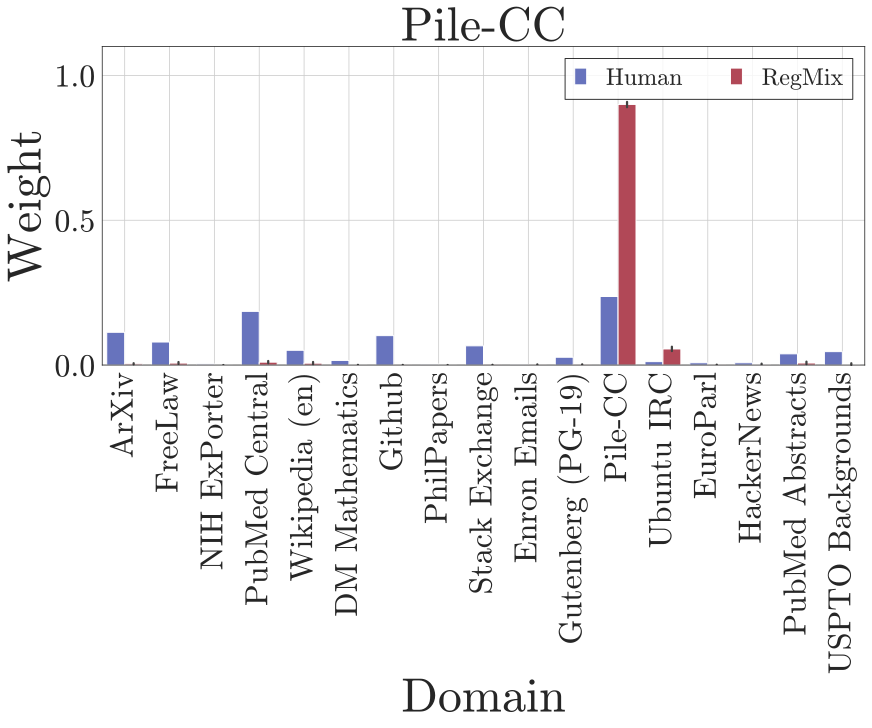

In [18]:
plt.rc('axes', unicode_minus=False)

plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })

fig, ax = plt.subplots(figsize=(12, 10), layout='compressed')

pal = {
    'Human':'#5969CB',
    'RegMix': '#C3364A',
}
sns.barplot(data=df, 
            x='variable', 
            y='value', 
            hue='type',
            palette=pal
           )

ax.tick_params(axis='x', labelrotation=90)

ax.legend(
    edgecolor='black', 
           fancybox=False,
           prop={'size': 24, }, 
             handlelength=0.5, 
    ncol=2,
)

ax.grid(True)

ax.set_ylim(0, 1.1)


ax.set_title(KEY_METRICS[selected], fontdict={
    'size': 48,
})
ax.set_xlabel('Domain', fontdict={
    'size': 48,
})
ax.set_ylabel('Weight', fontdict={
    'size': 48,
})

plt.savefig('viz/prior_vs_optimized.pdf', bbox_inches='tight', pad_inches=0.1)